In [2]:
import sys, os
import numpy as np
from matplotlib import pyplot as plt
from halotools import sim_manager
import h5py
from scipy import stats
from scipy import fftpack
from scipy.fftpack import fftfreq, fftshift, ifftshift, ifftn

/u/ayannam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
main_dir = "/u/ayannam/Documents/Raw_Data"
neu_data_dir = ["/mnv_0.0", "/mnv_0.1", "/mnv_0.6"]
red_data_dir = ["/out_37_parents_", "/out_42_parents_", "/out_47_parents_", "/out_56_parents_", "/out_66_parents_"]
red_r_data_dir = ["/out_37_", "/out_42_", "/out_47_", "/out_56_", "/out_66_"]
mass_data_dir = ["mass.npy", "con.npy", "spin.npy", "vmax.npy", "rs.npy", "rvir.npy"]

In [4]:
def get_init_density(mass, rs, rvir):
    init_density = mass - np.log10(4 * np.pi) - 2 * np.log10(rs) - (np.log10(np.log(1 + rvir / rs) - (rvir / (rs + rvir))))
    return init_density

In [71]:
def separate(mass_fn, con_fn, spin_fn, vmax_fn, rs_fn, rvir_fn, num_bins):

    # load the data
    mass = np.load(mass_fn)
    con = np.load(con_fn)
    vmax = np.load(vmax_fn)
    spin = np.load(spin_fn)
    rs = np.load(rs_fn)
    rvir = np.load(rvir_fn)
    
    init_density = get_init_density(mass, rs, rvir)
    
    bin_edges = np.linspace(np.min(mass), np.max(mass), num_bins + 1)

    vmax_normed = np.zeros(len(vmax))
    con_normed = np.zeros(len(con))
    spin_normed = np.zeros(len(spin))
    init_density_normed  = np.zeros(len(init_density))
    
    count = 0
    for b in bin_edges[1:]:
        upper_mask = mass >= bin_edges[count]
        lower_mask = mass <  b
        mask = upper_mask & lower_mask
        n_vmax = len(vmax[mask])
        n_con = len(con[mask])
        n_spin = len(spin[mask])
        n_init_density = len(init_density[mask])
        vmax_order = stats.rankdata(vmax[mask], method = "max") / n_vmax
        con_order = stats.rankdata(con[mask], method = "max") / n_con
        spin_order = stats.rankdata(spin[mask], method = "max") / n_spin
        init_density_order = stats.rankdata(init_density[mask], method = "max") / n_init_density
        vmax_normed[mask] = vmax_order
        con_normed[mask] = con_order
        spin_normed[mask] = spin_order
        init_density_normed[mask] = init_density_order
        count = count + 1

    return mass, vmax, con, spin, init_density, np.array(vmax_normed), np.array(con_normed), np.array(spin_normed), np.array(init_density_normed)
    
    #plt.xlabel("log10 Mass")
    #plt.ylabel("log10 Spin")|
    #plt.title("(7/19/18) log-log Mass Versus Spin Divided into 10ths")
    #plt.show()

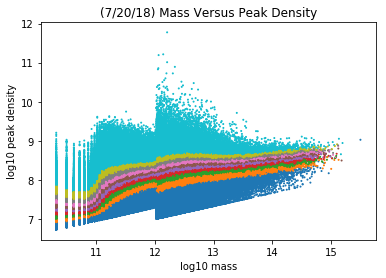

/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


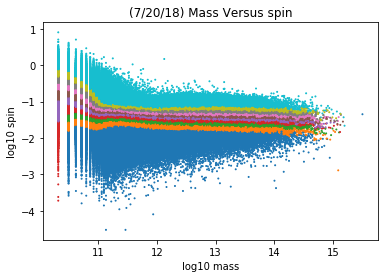

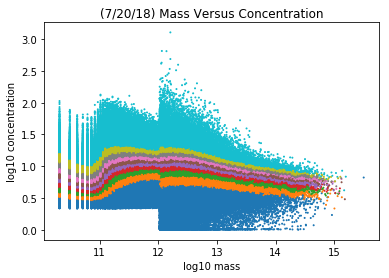

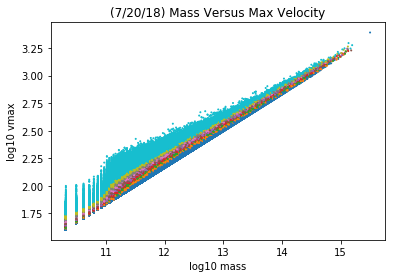

In [6]:
mass, vmax, con, spin, init_density, vmax_normed, con_normed, spin_normed, init_density_normed  = \
separate(main_dir + neu_data_dir[0] + red_data_dir[4] + mass_data_dir[0], \
         main_dir + neu_data_dir[0] + red_data_dir[4] + mass_data_dir[1], \
         main_dir + neu_data_dir[0] + red_data_dir[4] + mass_data_dir[2], \
         main_dir + neu_data_dir[0] + red_data_dir[4] + mass_data_dir[3], \
         main_dir + neu_data_dir[0] + red_r_data_dir[4] + mass_data_dir[4], \
         main_dir + neu_data_dir[0] + red_r_data_dir[4] + mass_data_dir[5], 100)

plt.scatter(mass, init_density, s = 1, c = init_density_normed, cmap = plt.cm.tab10)
plt.ylabel("log10 peak density")
plt.xlabel("log10 mass")
plt.title("(7/20/18) Mass Versus Peak Density")
plt.show()

plt.scatter(mass, np.log10(spin), s = 1, c = spin_normed, cmap = plt.cm.tab10)
plt.ylabel("log10 spin")
plt.xlabel("log10 mass")
plt.title("(7/20/18) Mass Versus spin")
plt.show()

plt.scatter(mass, np.log10(con), s = 1, c = con_normed, cmap = plt.cm.tab10)
plt.ylabel("log10 concentration")
plt.xlabel("log10 mass")
plt.title("(7/20/18) Mass Versus Concentration")
plt.show()

plt.scatter(mass, vmax, s = 1, c = vmax_normed, cmap = plt.cm.tab10)
plt.ylabel("log10 vmax")
plt.xlabel("log10 mass")
plt.title("(7/20/18) Mass Versus Max Velocity")
plt.show()

In [11]:
Lbox = 512.0 # size of box in Mpc/h
Ngrid = 256.0 # number of cells in 1D of grid for power spectrum

bin_centers = np.arange(Ngrid) # integer linear space up to number of cells for as bin centers
Lgrid = Lbox / Ngrid # the size of each individual grid cell

In [12]:
def gridding(halo_positions):
    # returns a 3D grid of the density of halos
    grid = np.histogramdd(halo_positions / Lgrid, bins = [bin_centers, bin_centers, bin_centers])[0]
    grid = grid / np.mean(grid) - 1
    return grid

def azimuthalAverage3D(grid, edges = None, logbins = True, bins = 50):
    z, y, x = np.indices(grid.shape)
    icenter=(x.max()-x.min())/2.0
    center = np.array([icenter, icenter, icenter])
     
    if grid.shape[0]%2 == 0:
        center+=0.5
     
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)#distance to center pixel, for each pixel
 
    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind] # the index to sort by r
    i_sorted = grid.flat[ind] # the index of the images sorted by r
 
    # find index that's corresponding to the lower edge of each bin
    kmin=1.0
    kmax=grid.shape[0]/2.0
    if edges == None:
        if logbins:
            edges = np.logspace(np.log10(kmin),np.log10(kmax),bins+1)
        else:
            #edges = linspace(kmin,kmax+0.001,bins+1)    
            edges = np.linspace(kmin,kmax,bins+1)
    if edges[0] > 0:
        edges = np.append([0],edges)
         
    hist_ind = np.histogram(r_sorted,bins = edges)[0] # hist_ind: the number in each ell bins, sum them up is the index of lower edge of each bin, first bin spans from 0 to left of first bin edge.    
    hist_sum = np.cumsum(hist_ind)
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[hist_sum[1:]] - csim[hist_sum[:-1]]
    radial_prof = tbin / hist_ind[1:]
    return edges[1:], radial_prof

edge2center = lambda x: x[:-1]+0.5*(x[1:]-x[:-1])

def PowerSpectrum3D(grid, logbins = True, bins=50):
    # Calculate the power spectrum for a cube.
    # Input:
    # grid = input grid in numpy array.
    # Output:
    # k, psd1D
    isize = grid.shape[0]
    F = fftshift(fftpack.fftn(grid))
    psd3D = np.abs(F)**2
    k_arr, psd1D = azimuthalAverage3D(psd3D, logbins = logbins, bins=bins)
    k_arr = edge2center(k_arr)
    return k_arr, psd1D
 
def process_ps(igrid):
    '''
    Comoput the power spectrum giving the positions of particles/halos.
    Input:
    The positions, output from either read_cat, or read_subsample
    Output: 
    k_normed: the k bin center
    ps3d_normed: the power spectrum
    '''
    k, ps3d = PowerSpectrum3D(igrid)
    k_normed, ps3d_normed = 2*np.pi*k/Lbox, ps3d*(Lgrid/Ngrid)**3
    return k_normed, ps3d_normed       

/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


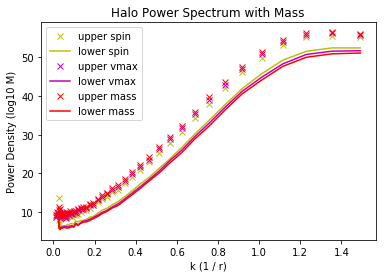

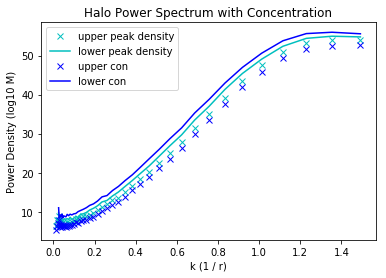

In [30]:
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_pos.npy")
PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_PID.npy")
mass, vmax, con, spin, init_density, vmax_normed, con_normed, spin_normed, init_density_normed  = \
separate(main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[0], \
         main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[1], \
         main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[2], \
         main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[3], \
         main_dir + neu_data_dir[0] + red_r_data_dir[0] + mass_data_dir[4], \
         main_dir + neu_data_dir[0] + red_r_data_dir[0] + mass_data_dir[5], 100)

mass_mask = mass > 12
parents_mask = PID == -1
use_mask = mass_mask & parents_mask

particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.0/snapshot_037.npy")

pos = pos[use_mask]
mass = mass[use_mask]
vmax = vmax[use_mask]
con = con[use_mask]
spin = spin[use_mask]

init_density = init_density[use_mask]
vmax_normed = vmax_normed[use_mask]
con_normed = con_normed[use_mask]
spin_normed = spin_normed[use_mask]
init_density_normed = init_density_normed[use_mask]

mass_med = np.median(mass)
vmax_med = np.median(vmax)
con_med = np.median(con)
spin_med = np.median(spin)
init_density_med = np.median(init_density)

kp, pp = process_ps(particle_grid)

upper_spin_mask = spin > spin_med
lower_spin_mask = spin <= spin_med

upper_spin_grid = gridding(pos[upper_spin_mask])
lower_spin_grid = gridding(pos[lower_spin_mask])
particle_grid = gridding(particles)

khus, phus = process_ps(upper_spin_grid)
khls, phls = process_ps(lower_spin_grid)

plt.plot(khus, phus / pp, "yx", label = "upper spin")
plt.plot(khls, phls / pp, "y", label = "lower spin")
plt.xlabel("k (1 / r)")
plt.ylabel("Power Density (log10 M)")
plt.title("Halo Power Spectrum with Spin")
plt.legend()

upper_vmax_mask = vmax > vmax_med
lower_vmax_mask = vmax <= vmax_med

upper_vmax_grid = gridding(pos[upper_vmax_mask])
lower_vmax_grid = gridding(pos[lower_vmax_mask])
particle_grid = gridding(particles)

khuv, phuv = process_ps(upper_vmax_grid)
khlv, phlv = process_ps(lower_vmax_grid)

plt.plot(khuv, phuv / pp, "mx", label = "upper vmax")
plt.plot(khlv, phlv / pp, "m", label = "lower vmax")
plt.xlabel("k (1 / r)")
plt.ylabel("Power Density (log10 M)")
plt.title("Halo Power Spectrum with Max Velocity")
plt.legend()


upper_init_density_mask = init_density > init_density_med
lower_init_density_mask = init_density <= init_density_med

upper_init_density_grid = gridding(pos[upper_init_density_mask])
lower_init_density_grid = gridding(pos[lower_init_density_mask])
particle_grid = gridding(particles)

khud, phud = process_ps(upper_init_density_grid)
khld, phld = process_ps(lower_init_density_grid)



plt.plot(khum, phum / pp, "rx", label = "upper mass")
plt.plot(khlm, phlm / pp, "r", label = "lower mass")
plt.xlabel("k (1 / r)")
plt.ylabel("Power Density (log10 M)")
plt.title("Halo Power Spectrum with Mass")
plt.legend()
plt.show()

plt.plot(khud, phud / pp, "cx", label = "upper peak density")
plt.plot(khld, phld / pp, "c", label = "lower peak density")
plt.xlabel("k (1 / r)")
plt.ylabel("Power Density (log10 M)")
plt.title("Halo Power Spectrum with Peak Density")
plt.legend()

upper_mass_mask = mass > mass_med
lower_mass_mask = mass <= mass_med

upper_mass_grid = gridding(pos[upper_mass_mask])
lower_mass_grid = gridding(pos[lower_mass_mask])
particle_grid = gridding(particles)

khum, phum = process_ps(upper_mass_grid)
khlm, phlm = process_ps(lower_mass_grid)

upper_con_mask = con > con_med
lower_con_mask = con <= con_med

upper_con_grid = gridding(pos[upper_con_mask])
lower_con_grid = gridding(pos[lower_con_mask])
particle_grid = gridding(particles)

khuc, phuc = process_ps(upper_con_grid)
khlc, phlc = process_ps(lower_con_grid)

plt.plot(khuc, phuc / pp, "bx", label = "upper con")
plt.plot(khlc, phlc / pp, "b", label = "lower con")
plt.xlabel("k (1 / r)")
plt.ylabel("Power Density (log10 M)")
plt.title("Halo Power Spectrum with Concentration")
plt.legend()
plt.show()

/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


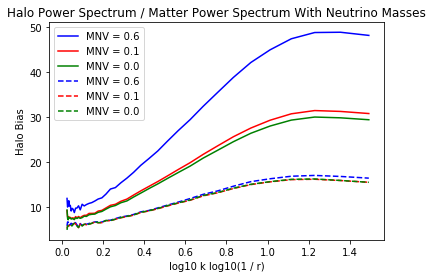

In [48]:
mass_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_mass.npy") > 12
parents_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_PID.npy") == -1
use_mask = mass_mask & parents_mask

pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_pos.npy")[use_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.6/snapshot_037.npy")

phh_grid = gridding(pos)
pmm_grid = (particle_grid)

kh, ph = process_ps(phh_grid)
kp, pp = process_ps(pmm_grid)

plt.plot(kh, ph / pp, color = "b", label = "MNV = 0.6")


mass_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_mass.npy") > 12
parents_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_PID.npy") == -1
use_mask = mass_mask & parents_mask

pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_pos.npy")[use_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.1/snapshot_037.npy")

phh_grid = gridding(pos)
pmm_grid = (particle_grid)

kh, ph = process_ps(phh_grid)
kp, pp = process_ps(pmm_grid)

plt.plot(kh, ph / pp, color = "r",label = "MNV = 0.1")


mass_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_mass.npy") > 12
parents_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_PID.npy") == -1
use_mask = mass_mask & parents_mask

pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_pos.npy")[use_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.0/snapshot_037.npy")

phh_grid = gridding(pos)
pmm_grid = (particle_grid)

kh, ph = process_ps(phh_grid)
kp, pp = process_ps(pmm_grid)

plt.plot(kh, ph / pp, color = "g",label = "MNV = 0.0")




####################################################################################################




mass_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_66_parents_mass.npy") > 12
parents_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_66_parents_PID.npy") == -1
use_mask = mass_mask & parents_mask

pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_66_parents_pos.npy")[use_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.6/snapshot_066.npy")

phh_grid = gridding(pos)
pmm_grid = (particle_grid)

kh, ph = process_ps(phh_grid)
kp, pp = process_ps(pmm_grid)

plt.plot(kh, ph / pp, "b--",label = "MNV = 0.6")


mass_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_66_parents_mass.npy") > 12
parents_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_66_parents_PID.npy") == -1
use_mask = mass_mask & parents_mask

pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_66_parents_pos.npy")[use_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.1/snapshot_066.npy")

phh_grid = gridding(pos)
pmm_grid = (particle_grid)

kh, ph = process_ps(phh_grid)
kp, pp = process_ps(pmm_grid)

plt.plot(kh, ph / pp, "r--",label = "MNV = 0.1")


mass_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_66_parents_mass.npy") > 12
parents_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_66_parents_PID.npy") == -1
use_mask = mass_mask & parents_mask

pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_66_parents_pos.npy")[use_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.0/snapshot_066.npy")

phh_grid = gridding(pos)
pmm_grid = (particle_grid)

kh, ph = process_ps(phh_grid)
kp, pp = process_ps(pmm_grid)

plt.plot(kh, ph / pp, "g--", label = "MNV = 0.0")


plt.legend()
plt.xlabel("log10 k log10(1 / r)")
plt.ylabel("Halo Bias")
plt.title("Halo Power Spectrum / Matter Power Spectrum With Neutrino Masses")
plt.show()

/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


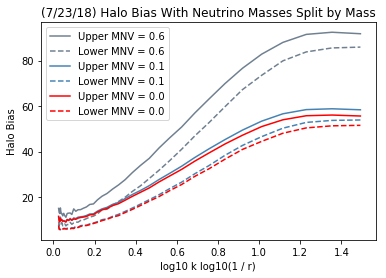

In [63]:
mass = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_mass.npy")
mass_mask = mass > 12
parents_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_PID.npy") == -1
use_mask = mass_mask & parents_mask
mass = mass[use_mask]

mass_median = np.median(mass)
mass_upper_mask = mass >= mass_median
mass_lower_mask = mass < mass_median

pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_pos.npy")[use_mask]
pos_upper = pos[mass_upper_mask]
pos_lower = pos[mass_lower_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.6/snapshot_037.npy")

phh_upper_grid = gridding(pos_upper)
phh_lower_grid = gridding(pos_lower)
pmm_grid = (particle_grid)

khu, phu = process_ps(phh_upper_grid)
khl, phl = process_ps(phh_lower_grid)
kp, pp = process_ps(pmm_grid)

plt.plot(khu, phu / pp, color = "slategray", label = "Upper MNV = 0.6")
plt.plot(khl, phl / pp, color = "slategray", linestyle = "dashed", label = "Lower MNV = 0.6")

##############################################################################################

mass = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_mass.npy")
mass_mask = mass > 12
parents_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_PID.npy") == -1
use_mask = mass_mask & parents_mask
mass = mass[use_mask]

mass_median = np.median(mass)
mass_upper_mask = mass >= mass_median
mass_lower_mask = mass < mass_median

pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_pos.npy")[use_mask]
pos_upper = pos[mass_upper_mask]
pos_lower = pos[mass_lower_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.1/snapshot_037.npy")

phh_upper_grid = gridding(pos_upper)
phh_lower_grid = gridding(pos_lower)
pmm_grid = (particle_grid)

khu, phu = process_ps(phh_upper_grid)
khl, phl = process_ps(phh_lower_grid)
kp, pp = process_ps(pmm_grid)

plt.plot(khu, phu / pp, color = "steelblue", label = "Upper MNV = 0.1")
plt.plot(khl, phl / pp, color = "steelblue", linestyle = "dashed", label = "Lower MNV = 0.1")

##############################################################################################

mass = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_mass.npy")
mass_mask = mass > 12
parents_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_PID.npy") == -1
use_mask = mass_mask & parents_mask
mass = mass[use_mask]

mass_median = np.median(mass)
mass_upper_mask = mass >= mass_median
mass_lower_mask = mass < mass_median

pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_pos.npy")[use_mask]
pos_upper = pos[mass_upper_mask]
pos_lower = pos[mass_lower_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.0/snapshot_037.npy")

phh_upper_grid = gridding(pos_upper)
phh_lower_grid = gridding(pos_lower)
pmm_grid = (particle_grid)

khu, phu = process_ps(phh_upper_grid)
khl, phl = process_ps(phh_lower_grid)
kp, pp = process_ps(pmm_grid)

plt.plot(khu, phu / pp, color = "r", label = "Upper MNV = 0.0")
plt.plot(khl, phl / pp, color = "r", linestyle = "dashed", label = "Lower MNV = 0.0")
plt.title("(7/23/18) Halo Bias With Neutrino Masses Split by Mass")
plt.xlabel("log10 k log10(1 / r)")
plt.ylabel("Halo Bias")
plt.legend()
plt.show()

/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


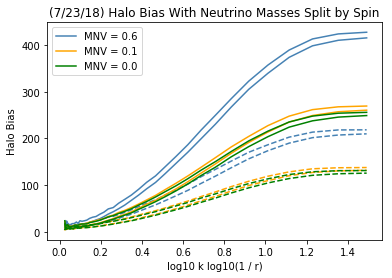

In [81]:
mass, vmax, con, spin, init_density, vmax_normed, con_normed, spin_normed, init_density_normed  = \
separate(main_dir + neu_data_dir[2] + red_data_dir[0] + mass_data_dir[0], \
         main_dir + neu_data_dir[2] + red_data_dir[0] + mass_data_dir[1], \
         main_dir + neu_data_dir[2] + red_data_dir[0] + mass_data_dir[2], \
         main_dir + neu_data_dir[2] + red_data_dir[0] + mass_data_dir[3], \
         main_dir + neu_data_dir[2] + red_r_data_dir[0] + mass_data_dir[4], \
         main_dir + neu_data_dir[2] + red_r_data_dir[0] + mass_data_dir[5], 100)

mass_mask = mass > 12
PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_PID.npy")
parents_mask = PID == -1
use_mask = mass_mask & parents_mask
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_pos.npy")[use_mask]

spin = spin[use_mask]
spin_normed = spin_normed[use_mask]

spin_upper_10_mask = spin_normed >= 0.9
spin_lower_10_mask = spin_normed <= 0.1
spin_upper_20_mask = spin_normed >= 0.8
spin_lower_20_mask = spin_normed <= 0.2

pos_upper_10 = pos[spin_upper_10_mask]
pos_lower_10 = pos[spin_lower_10_mask]
pos_upper_20 = pos[spin_upper_20_mask]
pos_lower_20 = pos[spin_lower_20_mask]

particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.6/snapshot_037.npy")

phh_upper_10_grid = gridding(pos_upper_10)
phh_lower_10_grid = gridding(pos_lower_10)
phh_upper_20_grid = gridding(pos_upper_20)
phh_lower_20_grid = gridding(pos_lower_20)
phh = gridding(pos)
pmm_grid = (particle_grid)


khu10, phu10 = process_ps(phh_upper_10_grid)
khl10, phl10 = process_ps(phh_lower_10_grid)
khu20, phu20 = process_ps(phh_upper_20_grid)
khl20, phl20 = process_ps(phh_lower_20_grid)
kh, ph = process_ps(phh)
kp, pp = process_ps(pmm_grid)

#plt.plot(kh, ph / pp, color = "steelblue", label = "MNV = 0.6")
plt.plot(khu10, phu10 / pp, color = "steelblue", label = "MNV = 0.6")
plt.plot(khl10, phl10 / pp, color = "steelblue")
plt.plot(khu20, phu20 / pp, color = "steelblue", linestyle = "dashed")
plt.plot(khl20, phl20 / pp, color = "steelblue", linestyle = "dashed")

#############################################################################################################

mass, vmax, con, spin, init_density, vmax_normed, con_normed, spin_normed, init_density_normed  = \
separate(main_dir + neu_data_dir[1] + red_data_dir[0] + mass_data_dir[0], \
         main_dir + neu_data_dir[1] + red_data_dir[0] + mass_data_dir[1], \
         main_dir + neu_data_dir[1] + red_data_dir[0] + mass_data_dir[2], \
         main_dir + neu_data_dir[1] + red_data_dir[0] + mass_data_dir[3], \
         main_dir + neu_data_dir[1] + red_r_data_dir[0] + mass_data_dir[4], \
         main_dir + neu_data_dir[1] + red_r_data_dir[0] + mass_data_dir[5], 100)

mass_mask = mass > 12
PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_PID.npy")
parents_mask = PID == -1
use_mask = mass_mask & parents_mask
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_pos.npy")[use_mask]

spin = spin[use_mask]
spin_normed = spin_normed[use_mask]
spin_upper_10_mask = spin_normed >= 0.9
spin_lower_10_mask = spin_normed <= 0.1
spin_upper_20_mask = spin_normed >= 0.8
spin_lower_20_mask = spin_normed <= 0.2

pos_upper_10 = pos[spin_upper_10_mask]
pos_lower_10 = pos[spin_lower_10_mask]
pos_upper_20 = pos[spin_upper_20_mask]
pos_lower_20 = pos[spin_lower_20_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.1/snapshot_037.npy")

phh_upper_10_grid = gridding(pos_upper_10)
phh_lower_10_grid = gridding(pos_lower_10)
phh_upper_20_grid = gridding(pos_upper_20)
phh_lower_20_grid = gridding(pos_lower_20)
phh = gridding(pos)
pmm_grid = (particle_grid)


khu10, phu10 = process_ps(phh_upper_10_grid)
khl10, phl10 = process_ps(phh_lower_10_grid)
khu20, phu20 = process_ps(phh_upper_20_grid)
khl20, phl20 = process_ps(phh_lower_20_grid)
kh, ph = process_ps(phh)
kp, pp = process_ps(pmm_grid)

#plt.plot(kh, ph / pp, color = "orange", label = "MNV = 0.1")
plt.plot(khu10, phu10 / pp, color = "orange", label = "MNV = 0.1")
plt.plot(khl10, phl10 / pp, color = "orange")
plt.plot(khu20, phu20 / pp, color = "orange", linestyle = "dashed")
plt.plot(khl20, phl20 / pp, color = "orange", linestyle = "dashed")

#############################################################################################################

mass, vmax, con, spin, init_density, vmax_normed, con_normed, spin_normed, init_density_normed  = \
separate(main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[0], \
         main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[1], \
         main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[2], \
         main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[3], \
         main_dir + neu_data_dir[0] + red_r_data_dir[0] + mass_data_dir[4], \
         main_dir + neu_data_dir[0] + red_r_data_dir[0] + mass_data_dir[5], 100)

mass_mask = mass > 12
PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_PID.npy")
parents_mask = PID == -1
use_mask = mass_mask & parents_mask
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_pos.npy")[use_mask]

spin = spin[use_mask]
spin_normed = spin_normed[use_mask]
spin_upper_10_mask = spin_normed >= 0.9
spin_lower_10_mask = spin_normed <= 0.1
spin_upper_20_mask = spin_normed >= 0.8
spin_lower_20_mask = spin_normed <= 0.2

pos_upper_10 = pos[spin_upper_10_mask]
pos_lower_10 = pos[spin_lower_10_mask]
pos_upper_20 = pos[spin_upper_20_mask]
pos_lower_20 = pos[spin_lower_20_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.0/snapshot_037.npy")

phh_upper_10_grid = gridding(pos_upper_10)
phh_lower_10_grid = gridding(pos_lower_10)
phh_upper_20_grid = gridding(pos_upper_20)
phh_lower_20_grid = gridding(pos_lower_20)
phh = gridding(pos)
pmm_grid = (particle_grid)


khu10, phu10 = process_ps(phh_upper_10_grid)
khl10, phl10 = process_ps(phh_lower_10_grid)
khu20, phu20 = process_ps(phh_upper_20_grid)
khl20, phl20 = process_ps(phh_lower_20_grid)
kh, ph = process_ps(phh)
kp, pp = process_ps(pmm_grid)

#plt.plot(kh, ph / pp, color = "g", label = "MNV = 0.0")
plt.plot(khu10, phu10 / pp, color = "g", label = "MNV = 0.0")
plt.plot(khl10, phl10 / pp, color = "g")
plt.plot(khu20, phu20 / pp, color = "g", linestyle = "dashed")
plt.plot(khl20, phl20 / pp, color = "g", linestyle = "dashed")

plt.title("(7/23/18) Halo Bias With Neutrino Masses Split by Spin")
plt.xlabel("log10 k log10(1 / r)")
plt.ylabel("Halo Bias")
plt.legend()
plt.show()


/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


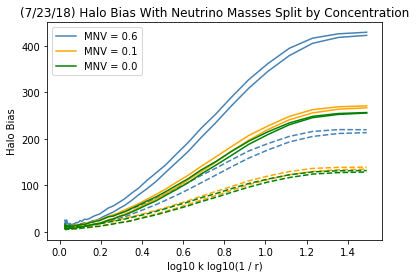

In [87]:
mass, vmax, con, spin, init_density, vmax_normed, con_normed, spin_normed, init_density_normed  = \
separate(main_dir + neu_data_dir[2] + red_data_dir[0] + mass_data_dir[0], \
         main_dir + neu_data_dir[2] + red_data_dir[0] + mass_data_dir[1], \
         main_dir + neu_data_dir[2] + red_data_dir[0] + mass_data_dir[2], \
         main_dir + neu_data_dir[2] + red_data_dir[0] + mass_data_dir[3], \
         main_dir + neu_data_dir[2] + red_r_data_dir[0] + mass_data_dir[4], \
         main_dir + neu_data_dir[2] + red_r_data_dir[0] + mass_data_dir[5], 100)

mass_mask = mass > 12
PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_PID.npy")
parents_mask = PID == -1
use_mask = mass_mask & parents_mask
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_pos.npy")[use_mask]

con = con[use_mask]
con_normed = con_normed[use_mask]
con_upper_10_mask = con_normed >= 0.9
con_lower_10_mask = con_normed <= 0.1
con_upper_20_mask = con_normed >= 0.8
con_lower_20_mask = con_normed <= 0.2

pos_upper_10 = pos[con_upper_10_mask]
pos_lower_10 = pos[con_lower_10_mask]
pos_upper_20 = pos[con_upper_20_mask]
pos_lower_20 = pos[con_lower_20_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.6/snapshot_037.npy")

phh_upper_10_grid = gridding(pos_upper_10)
phh_lower_10_grid = gridding(pos_lower_10)
phh_upper_20_grid = gridding(pos_upper_20)
phh_lower_20_grid = gridding(pos_lower_20)
phh = gridding(pos)
pmm_grid = (particle_grid)


khu10, phu10 = process_ps(phh_upper_10_grid)
khl10, phl10 = process_ps(phh_lower_10_grid)
khu20, phu20 = process_ps(phh_upper_20_grid)
khl20, phl20 = process_ps(phh_lower_20_grid)
kh, ph = process_ps(phh)
kp, pp = process_ps(pmm_grid)

#plt.plot(kh, ph / pp, color = "steelblue", label = "MNV = 0.6")
plt.plot(khu10, phu10 / pp, color = "steelblue", label = "MNV = 0.6")
plt.plot(khl10, phl10 / pp, color = "steelblue")
plt.plot(khu20, phu20 / pp, color = "steelblue", linestyle = "dashed")
plt.plot(khl20, phl20 / pp, color = "steelblue", linestyle = "dashed")

#############################################################################################################

mass, vmax, con, spin, init_density, vmax_normed, con_normed, spin_normed, init_density_normed  = \
separate(main_dir + neu_data_dir[1] + red_data_dir[0] + mass_data_dir[0], \
         main_dir + neu_data_dir[1] + red_data_dir[0] + mass_data_dir[1], \
         main_dir + neu_data_dir[1] + red_data_dir[0] + mass_data_dir[2], \
         main_dir + neu_data_dir[1] + red_data_dir[0] + mass_data_dir[3], \
         main_dir + neu_data_dir[1] + red_r_data_dir[0] + mass_data_dir[4], \
         main_dir + neu_data_dir[1] + red_r_data_dir[0] + mass_data_dir[5], 100)

mass_mask = mass > 12
PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_PID.npy")
parents_mask = PID == -1
use_mask = mass_mask & parents_mask
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_pos.npy")[use_mask]

con = con[use_mask]
con_normed = con_normed[use_mask]
con_upper_10_mask = con_normed >= 0.9
con_lower_10_mask = con_normed <= 0.1
con_upper_20_mask = con_normed >= 0.8
con_lower_20_mask = con_normed <= 0.2

pos_upper_10 = pos[con_upper_10_mask]
pos_lower_10 = pos[con_lower_10_mask]
pos_upper_20 = pos[con_upper_20_mask]
pos_lower_20 = pos[con_lower_20_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.1/snapshot_037.npy")

phh_upper_10_grid = gridding(pos_upper_10)
phh_lower_10_grid = gridding(pos_lower_10)
phh_upper_20_grid = gridding(pos_upper_20)
phh_lower_20_grid = gridding(pos_lower_20)
phh = gridding(pos)
pmm_grid = (particle_grid)


khu10, phu10 = process_ps(phh_upper_10_grid)
khl10, phl10 = process_ps(phh_lower_10_grid)
khu20, phu20 = process_ps(phh_upper_20_grid)
khl20, phl20 = process_ps(phh_lower_20_grid)
kh, ph = process_ps(phh)
kp, pp = process_ps(pmm_grid)

#plt.plot(kh, ph / pp, color = "orange", label = "MNV = 0.1")
plt.plot(khu10, phu10 / pp, color = "orange", label = "MNV = 0.1")
plt.plot(khl10, phl10 / pp, color = "orange")
plt.plot(khu20, phu20 / pp, color = "orange", linestyle = "dashed")
plt.plot(khl20, phl20 / pp, color = "orange", linestyle = "dashed")


#############################################################################################################

mass, vmax, con, spin, init_density, vmax_normed, con_normed, spin_normed, init_density_normed  = \
separate(main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[0], \
         main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[1], \
         main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[2], \
         main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[3], \
         main_dir + neu_data_dir[0] + red_r_data_dir[0] + mass_data_dir[4], \
         main_dir + neu_data_dir[0] + red_r_data_dir[0] + mass_data_dir[5], 100)

mass_mask = mass > 12
PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_PID.npy")
parents_mask = PID == -1
use_mask = mass_mask & parents_mask
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_pos.npy")[use_mask]

con = con[use_mask]
con_normed = con_normed[use_mask]
con_upper_10_mask = con_normed >= 0.9
con_lower_10_mask = con_normed <= 0.1
con_upper_20_mask = con_normed >= 0.8
con_lower_20_mask = con_normed <= 0.2

pos_upper_10 = pos[con_upper_10_mask]
pos_lower_10 = pos[con_lower_10_mask]
pos_upper_20 = pos[con_upper_20_mask]
pos_lower_20 = pos[con_lower_20_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.0/snapshot_037.npy")

phh_upper_10_grid = gridding(pos_upper_10)
phh_lower_10_grid = gridding(pos_lower_10)
phh_upper_20_grid = gridding(pos_upper_20)
phh_lower_20_grid = gridding(pos_lower_20)
phh = gridding(pos)
pmm_grid = (particle_grid)


khu10, phu10 = process_ps(phh_upper_10_grid)
khl10, phl10 = process_ps(phh_lower_10_grid)
khu20, phu20 = process_ps(phh_upper_20_grid)
khl20, phl20 = process_ps(phh_lower_20_grid)
kh, ph = process_ps(phh)
kp, pp = process_ps(pmm_grid)

#plt.plot(kh, ph / pp, color = "g", label = "MNV = 0.0")
plt.plot(khu10, phu10 / pp, color = "g", label = "MNV = 0.0")
plt.plot(khl10, phl10 / pp, color = "g")
plt.plot(khu20, phu20 / pp, color = "g", linestyle = "dashed")
plt.plot(khl20, phl20 / pp, color = "g", linestyle = "dashed")

plt.title("(7/23/18) Halo Bias With Neutrino Masses Split by Concentration")
plt.xlabel("log10 k log10(1 / r)")
plt.ylabel("Halo Bias")
plt.legend()
plt.show()


/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


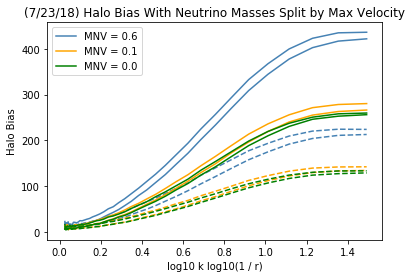

In [88]:
mass, vmax, con, spin, init_density, vmax_normed, con_normed, spin_normed, init_density_normed  = \
separate(main_dir + neu_data_dir[2] + red_data_dir[0] + mass_data_dir[0], \
         main_dir + neu_data_dir[2] + red_data_dir[0] + mass_data_dir[1], \
         main_dir + neu_data_dir[2] + red_data_dir[0] + mass_data_dir[2], \
         main_dir + neu_data_dir[2] + red_data_dir[0] + mass_data_dir[3], \
         main_dir + neu_data_dir[2] + red_r_data_dir[0] + mass_data_dir[4], \
         main_dir + neu_data_dir[2] + red_r_data_dir[0] + mass_data_dir[5], 100)

mass_mask = mass > 12
PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_PID.npy")
parents_mask = PID == -1
use_mask = mass_mask & parents_mask
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_pos.npy")[use_mask]

vmax = vmax[use_mask]
vmax_normed = vmax_normed[use_mask]
vmax_upper_10_mask = vmax_normed >= 0.9
vmax_lower_10_mask = vmax_normed <= 0.1
vmax_upper_20_mask = vmax_normed >= 0.8
vmax_lower_20_mask = vmax_normed <= 0.2

pos_upper_10 = pos[vmax_upper_10_mask]
pos_lower_10 = pos[vmax_lower_10_mask]
pos_upper_20 = pos[vmax_upper_20_mask]
pos_lower_20 = pos[vmax_lower_20_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.6/snapshot_037.npy")

phh_upper_10_grid = gridding(pos_upper_10)
phh_lower_10_grid = gridding(pos_lower_10)
phh_upper_20_grid = gridding(pos_upper_20)
phh_lower_20_grid = gridding(pos_lower_20)
phh = gridding(pos)
pmm_grid = (particle_grid)


khu10, phu10 = process_ps(phh_upper_10_grid)
khl10, phl10 = process_ps(phh_lower_10_grid)
khu20, phu20 = process_ps(phh_upper_20_grid)
khl20, phl20 = process_ps(phh_lower_20_grid)
kh, ph = process_ps(phh)
kp, pp = process_ps(pmm_grid)

#plt.plot(kh, ph / pp, color = "steelblue", label = "MNV = 0.6")
plt.plot(khu10, phu10 / pp, color = "steelblue", label = "MNV = 0.6")
plt.plot(khl10, phl10 / pp, color = "steelblue")
plt.plot(khu20, phu20 / pp, color = "steelblue", linestyle = "dashed")
plt.plot(khl20, phl20 / pp, color = "steelblue", linestyle = "dashed")

#############################################################################################################

mass, vmax, con, spin, init_density, vmax_normed, con_normed, spin_normed, init_density_normed  = \
separate(main_dir + neu_data_dir[1] + red_data_dir[0] + mass_data_dir[0], \
         main_dir + neu_data_dir[1] + red_data_dir[0] + mass_data_dir[1], \
         main_dir + neu_data_dir[1] + red_data_dir[0] + mass_data_dir[2], \
         main_dir + neu_data_dir[1] + red_data_dir[0] + mass_data_dir[3], \
         main_dir + neu_data_dir[1] + red_r_data_dir[0] + mass_data_dir[4], \
         main_dir + neu_data_dir[1] + red_r_data_dir[0] + mass_data_dir[5], 100)

mass_mask = mass > 12
PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_PID.npy")
parents_mask = PID == -1
use_mask = mass_mask & parents_mask
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_pos.npy")[use_mask]

vmax = vmax[use_mask]
vmax_normed = vmax_normed[use_mask]
vmax_upper_10_mask = vmax_normed >= 0.9
vmax_lower_10_mask = vmax_normed <= 0.1
vmax_upper_20_mask = vmax_normed >= 0.8
vmax_lower_20_mask = vmax_normed <= 0.2

pos_upper_10 = pos[vmax_upper_10_mask]
pos_lower_10 = pos[vmax_lower_10_mask]
pos_upper_20 = pos[vmax_upper_20_mask]
pos_lower_20 = pos[vmax_lower_20_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.1/snapshot_037.npy")

phh_upper_10_grid = gridding(pos_upper_10)
phh_lower_10_grid = gridding(pos_lower_10)
phh_upper_20_grid = gridding(pos_upper_20)
phh_lower_20_grid = gridding(pos_lower_20)
phh = gridding(pos)
pmm_grid = (particle_grid)


khu10, phu10 = process_ps(phh_upper_10_grid)
khl10, phl10 = process_ps(phh_lower_10_grid)
khu20, phu20 = process_ps(phh_upper_20_grid)
khl20, phl20 = process_ps(phh_lower_20_grid)
kh, ph = process_ps(phh)
kp, pp = process_ps(pmm_grid)

#plt.plot(kh, ph / pp, color = "orange", label = "MNV = 0.1")
plt.plot(khu10, phu10 / pp, color = "orange", label = "MNV = 0.1")
plt.plot(khl10, phl10 / pp, color = "orange")
plt.plot(khu20, phu20 / pp, color = "orange", linestyle = "dashed")
plt.plot(khl20, phl20 / pp, color = "orange", linestyle = "dashed")


#############################################################################################################

mass, vmax, con, spin, init_density, vmax_normed, con_normed, spin_normed, init_density_normed  = \
separate(main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[0], \
         main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[1], \
         main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[2], \
         main_dir + neu_data_dir[0] + red_data_dir[0] + mass_data_dir[3], \
         main_dir + neu_data_dir[0] + red_r_data_dir[0] + mass_data_dir[4], \
         main_dir + neu_data_dir[0] + red_r_data_dir[0] + mass_data_dir[5], 100)

mass_mask = mass > 12
PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_PID.npy")
parents_mask = PID == -1
use_mask = mass_mask & parents_mask
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_pos.npy")[use_mask]

vmax = vmax[use_mask]
vmax_normed = vmax_normed[use_mask]
vmax_upper_10_mask = vmax_normed >= 0.9
vmax_lower_10_mask = vmax_normed <= 0.1
vmax_upper_20_mask = vmax_normed >= 0.8
vmax_lower_20_mask = vmax_normed <= 0.2

pos_upper_10 = pos[vmax_upper_10_mask]
pos_lower_10 = pos[vmax_lower_10_mask]
pos_upper_20 = pos[vmax_upper_20_mask]
pos_lower_20 = pos[vmax_lower_20_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.0/snapshot_037.npy")

phh_upper_10_grid = gridding(pos_upper_10)
phh_lower_10_grid = gridding(pos_lower_10)
phh_upper_20_grid = gridding(pos_upper_20)
phh_lower_20_grid = gridding(pos_lower_20)
phh = gridding(pos)
pmm_grid = (particle_grid)


khu10, phu10 = process_ps(phh_upper_10_grid)
khl10, phl10 = process_ps(phh_lower_10_grid)
khu20, phu20 = process_ps(phh_upper_20_grid)
khl20, phl20 = process_ps(phh_lower_20_grid)
kh, ph = process_ps(phh)
kp, pp = process_ps(pmm_grid)

#plt.plot(kh, ph / pp, color = "g", label = "MNV = 0.0")
plt.plot(khu10, phu10 / pp, color = "g", label = "MNV = 0.0")
plt.plot(khl10, phl10 / pp, color = "g")
plt.plot(khu20, phu20 / pp, color = "g", linestyle = "dashed")
plt.plot(khl20, phl20 / pp, color = "g", linestyle = "dashed")

plt.title("(7/23/18) Halo Bias With Neutrino Masses Split by Max Velocity")
plt.xlabel("log10 k log10(1 / r)")
plt.ylabel("Halo Bias")
plt.legend()
plt.show()


/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


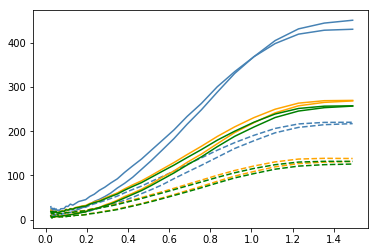

In [86]:
mass = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_mass.npy")
mass_mask = mass > 12
parents_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_PID.npy") == -1
use_mask = mass_mask & parents_mask
mass = mass[use_mask]
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.6/out_37_parents_pos.npy")[use_mask]

mass_normed  = stats.rankdata(mass, method = "max") / len(mass)
mass_upper_10_mask = mass_normed >= 0.9
mass_lower_10_mask = mass_normed <= 0.1
mass_upper_20_mask = mass_normed >= 0.8
mass_lower_20_mask = mass_normed <= 0.2

pos_upper_10 = pos[mass_upper_10_mask]
pos_lower_10 = pos[mass_lower_10_mask]
pos_upper_20 = pos[mass_upper_20_mask]
pos_lower_20 = pos[mass_lower_20_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.6/snapshot_037.npy")

phh_upper_10_grid = gridding(pos_upper_10)
phh_lower_10_grid = gridding(pos_lower_10)
phh_upper_20_grid = gridding(pos_upper_20)
phh_lower_20_grid = gridding(pos_lower_20)
phh = gridding(pos)
pmm_grid = (particle_grid)


khu10, phu10 = process_ps(phh_upper_10_grid)
khl10, phl10 = process_ps(phh_lower_10_grid)
khu20, phu20 = process_ps(phh_upper_20_grid)
khl20, phl20 = process_ps(phh_lower_20_grid)
kh, ph = process_ps(phh)
kp, pp = process_ps(pmm_grid)

plt.plot(khu10, phu10 / pp, color = "steelblue", label = "MNV = 0.6")
plt.plot(khl10, phl10 / pp, color = "steelblue")
plt.plot(khu20, phu20 / pp, color = "steelblue", linestyle = "dashed")
plt.plot(khl20, phl20 / pp, color = "steelblue", linestyle = "dashed")

##############################################################################################

mass = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_mass.npy")
mass_mask = mass > 12
parents_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_PID.npy") == -1
use_mask = mass_mask & parents_mask
mass = mass[use_mask]
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_37_parents_pos.npy")[use_mask]

mass_normed  = stats.rankdata(mass, method = "max") / len(mass)
mass_upper_10_mask = mass_normed >= 0.9
mass_lower_10_mask = mass_normed <= 0.1
mass_upper_20_mask = mass_normed >= 0.8
mass_lower_20_mask = mass_normed <= 0.2

pos_upper_10 = pos[mass_upper_10_mask]
pos_lower_10 = pos[mass_lower_10_mask]
pos_upper_20 = pos[mass_upper_20_mask]
pos_lower_20 = pos[mass_lower_20_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.1/snapshot_037.npy")

phh_upper_10_grid = gridding(pos_upper_10)
phh_lower_10_grid = gridding(pos_lower_10)
phh_upper_20_grid = gridding(pos_upper_20)
phh_lower_20_grid = gridding(pos_lower_20)
phh = gridding(pos)
pmm_grid = (particle_grid)


khu10, phu10 = process_ps(phh_upper_10_grid)
khl10, phl10 = process_ps(phh_lower_10_grid)
khu20, phu20 = process_ps(phh_upper_20_grid)
khl20, phl20 = process_ps(phh_lower_20_grid)
kh, ph = process_ps(phh)
kp, pp = process_ps(pmm_grid)

plt.plot(khu10, phu10 / pp, color = "orange", label = "MNV = 0.1")
plt.plot(khl10, phl10 / pp, color = "orange")
plt.plot(khu20, phu20 / pp, color = "orange", linestyle = "dashed")
plt.plot(khl20, phl20 / pp, color = "orange", linestyle = "dashed")

######################################################################################################

mass = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_mass.npy")
mass_mask = mass > 12
parents_mask = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_PID.npy") == -1
use_mask = mass_mask & parents_mask
mass = mass[use_mask]
pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_0.0/out_37_parents_pos.npy")[use_mask]

mass_normed  = stats.rankdata(mass, method = "max") / len(mass)
mass_upper_10_mask = mass_normed >= 0.9
mass_lower_10_mask = mass_normed <= 0.1
mass_upper_20_mask = mass_normed >= 0.8
mass_lower_20_mask = mass_normed <= 0.2

pos_upper_10 = pos[mass_upper_10_mask]
pos_lower_10 = pos[mass_lower_10_mask]
pos_upper_20 = pos[mass_upper_20_mask]
pos_lower_20 = pos[mass_lower_20_mask]
particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_0.0/snapshot_037.npy")

phh_upper_10_grid = gridding(pos_upper_10)
phh_lower_10_grid = gridding(pos_lower_10)
phh_upper_20_grid = gridding(pos_upper_20)
phh_lower_20_grid = gridding(pos_lower_20)
phh = gridding(pos)
pmm_grid = (particle_grid)


khu10, phu10 = process_ps(phh_upper_10_grid)
khl10, phl10 = process_ps(phh_lower_10_grid)
khu20, phu20 = process_ps(phh_upper_20_grid)
khl20, phl20 = process_ps(phh_lower_20_grid)
kh, ph = process_ps(phh)
kp, pp = process_ps(pmm_grid)

plt.plot(khu10, phu10 / pp, color = "g", label = "MNV = 0.0")
plt.plot(khl10, phl10 / pp, color = "g")
plt.plot(khu20, phu20 / pp, color = "g", linestyle = "dashed")
plt.plot(khl20, phl20 / pp, color = "g", linestyle = "dashed")
plt.legend()
plt.title("(7/23/18) Halo Bias With Neutrino Masses Split by Mass")
plt.show()
